# TP 2: Image segmentation with Neural Network

## Objective:
- Introduction to Pytorch (see previous tutorial notebook)
- Define a simple neural network
- Define a training procedure
- Compare difference optimization methods
- Enhance your coding skills

We consider an image as a function from $\Omega$ to $\mathbb{R}$, where $\Omega$ is a discretization of the space $[0,1]^2$. In this notebook, we suppose that we can partition $\Omega$ into $2$ regular domains $\Omega_1$ and $\Omega_2 = \Omega /  \Omega_1$.

On each domain, we suppose that the image has different textures. We will generate these textures as stationary Gaussian processes:
- We will first generate a Gaussian noise. 
- We will then convolve this noise with a filter which describes the covariance matrix of the process. 



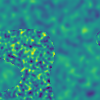
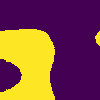


Above is an example of an image and its partition $\Omega_1$ and $\Omega_2$. The objective is from the image on the left, train a neural network to predict the mask on the right.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

Define your device and data type

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
factory_kwargs = {'device': device, 'dtype': dtype}

print("factory_kwargs: ", factory_kwargs)

factory_kwargs:  {'device': device(type='cuda'), 'dtype': torch.float32}


In [3]:
torch.manual_seed(42)

### Generating data

The following function will generate a batch of data with shape `(batch_size, 1, image_size, image_size)`
Take a look at this function and try to understand what it does. 

In [4]:
def generate_data(batch_size: int, 
                  image_size: int = 128, 
                  sigma1: float = 1., 
                  sigma2: float = 0.2, 
                  sigma: float = 25,
                  **factory_kwargs) -> torch.Tensor:
    
    # Defining a grid directly on device, without the need of calling `.to(device)` method,
    # which is time consuming.
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x,y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # We define a random smooth partition
    b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution

    omega_1 = gp > 0
    omega_2 = ~omega_1
    
    # We define two Gaussian random processes with different statistics
    b1 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp1 = F.conv2d(b1, g1[None,None], padding = 'same')
    
    b2 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp2 = F.conv2d(b2, g2[None,None], padding = 'same')
    
    # Now we put each process at the right place
    image = gp1 * omega_1 + gp2 * omega_2
    # We smooth the result to avoid having a jump at the interfaces
    image =  F.conv2d(image, g3[None,None], padding = 'same')

    # We normalize the image in to [0,1]
    image = normalize_to_01(image)
    
    return image, omega_1.to(**factory_kwargs)
    

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim = (-2, -1), keepdim=True)
    input /= input.amax(dim = (-2, -1), keepdim=True)
    return input

Let's take a look at the data and its structure

/tmp/ipykernel_64233/3741924848.py:31: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Convolution.cpp:1008.)
  gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution


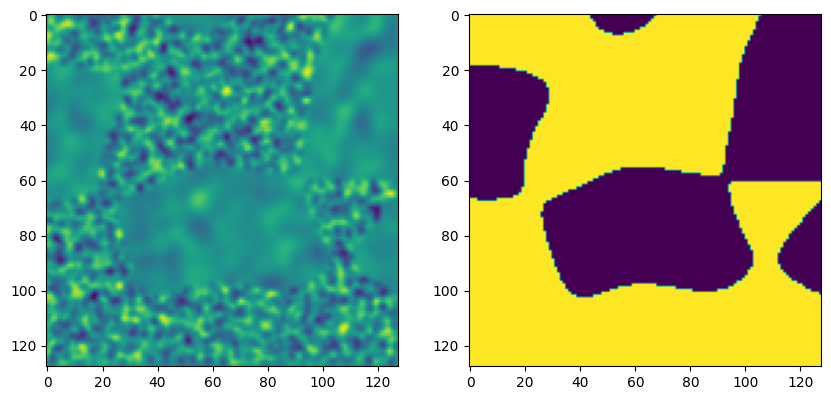

In [5]:
image, mask = generate_data(batch_size = 1, 
                            image_size=128,
                            sigma1=0.2,
                            sigma2=2.5, 
                            sigma=15, **factory_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

In [6]:
print("image.shape: ", image.shape)
print("mask.shape: ", mask.shape)

print(mask[0])

image.shape:  torch.Size([1, 1, 128, 128])
mask.shape:  torch.Size([1, 1, 128, 128])
tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')


A more efficient way to generate a 2D Gaussian is in following, let have a look at this function and try to understand the difference.

In [7]:
def gaussian(image_size, sigma, **factory_kwargs):
    linspace = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    distance = linspace[None,:] ** 2 + linspace[:,None] ** 2
    
    # Defining 4 Gaussian
    g = torch.exp(-distance / (2 * sigma**2))
    g = g / torch.sum(g)

    return g

## Define your neural network

In [8]:
class MyFirtsCNN(nn.Module):
    def __init__(self, num_channels=16, kernel_size = 5, bias=True):
        super().__init__()

        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_channels)
        self.bias = bias
        self.kernel_size = kernel_size
        self.pad = int((self.kernel_size - 1) / 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=bias,
            ),
            self.activation,
            self.bn
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )

        self.out = nn.Conv2d(
                in_channels=num_channels,
                out_channels=1,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        output = torch.sigmoid(self.out(x3))
        return output


### Question: How many layers do we have in the network? What are the activation functions?

### Question : Explain why we have a `sigmoid` activation at the end of the network? Write the training optimization problem.

In [9]:
model = MyFirtsCNN(num_channels=16, kernel_size = 5)

Let see how many parameters you have in your model.

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters: ", count_parameters(model))

Number of parameters:  13681


In [11]:

# By default, the model (i.e., the trainable parameters) is stored in CPU
print(next(model.parameters()).device)
# You have to push your to GPU if you want to use GPU
model = model.to(device)
print(next(model.parameters()).device)


cpu
cuda:0


### Question: Verify your model output shape? The link with the input shape?

In [12]:
print("Input shape: ", image.shape)
print("Output shape: ", model(image).shape)

Input shape:  torch.Size([1, 1, 128, 128])
Output shape:  torch.Size([1, 1, 128, 128])


## Define your optimization algorithm

The optimization algorithms are defined in `torch.optim`. We need to pass all the trainable parameters to the optimizer, along with other hyperparameters such as the learning rate, ...

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Training the model

Define your training hyperparameters

In [14]:
from tqdm.auto import tqdm

Below is an example of how to train a neural network. Look at these line of code carefully and understand what is does. 

  0%|          | 0/10000 [00:00<?, ?it/s]

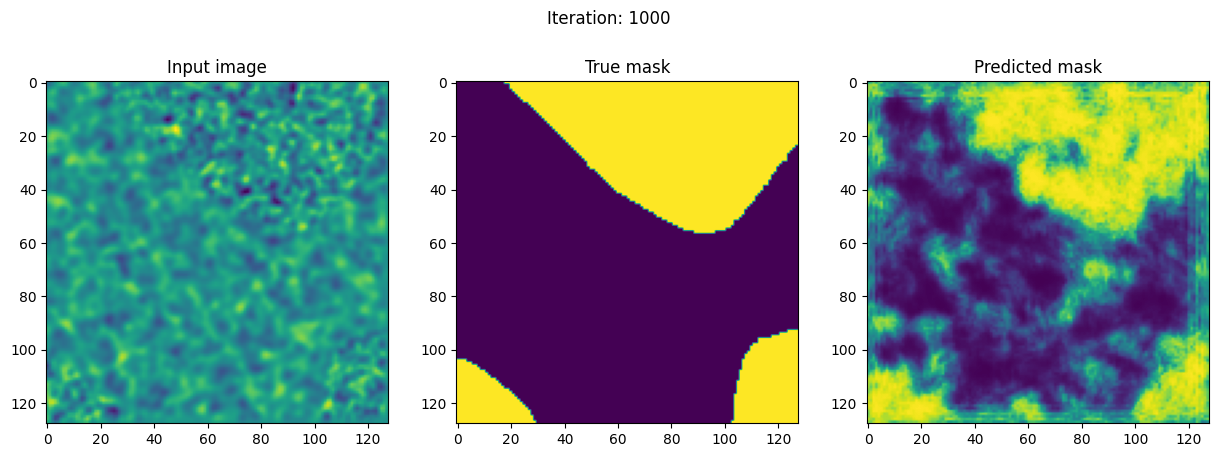

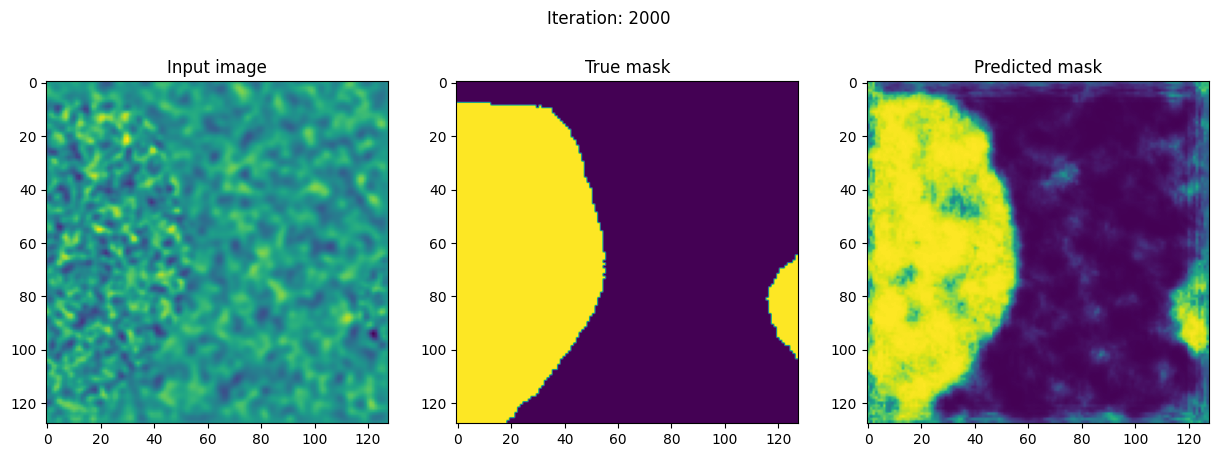

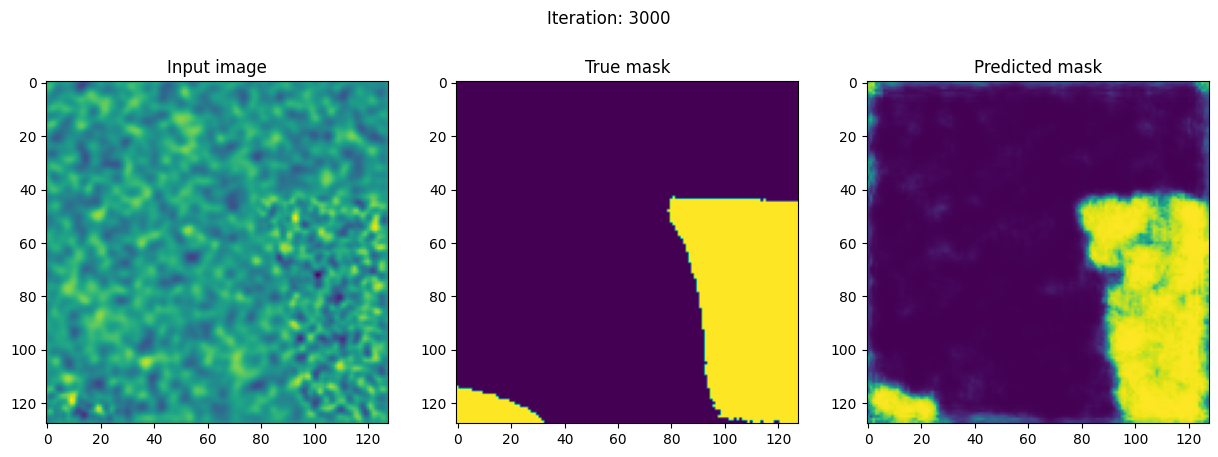

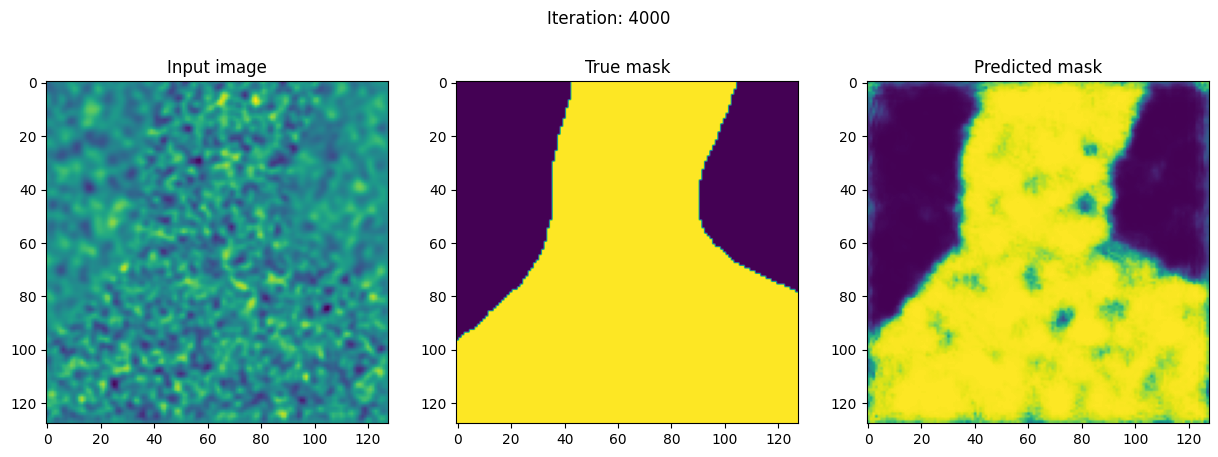

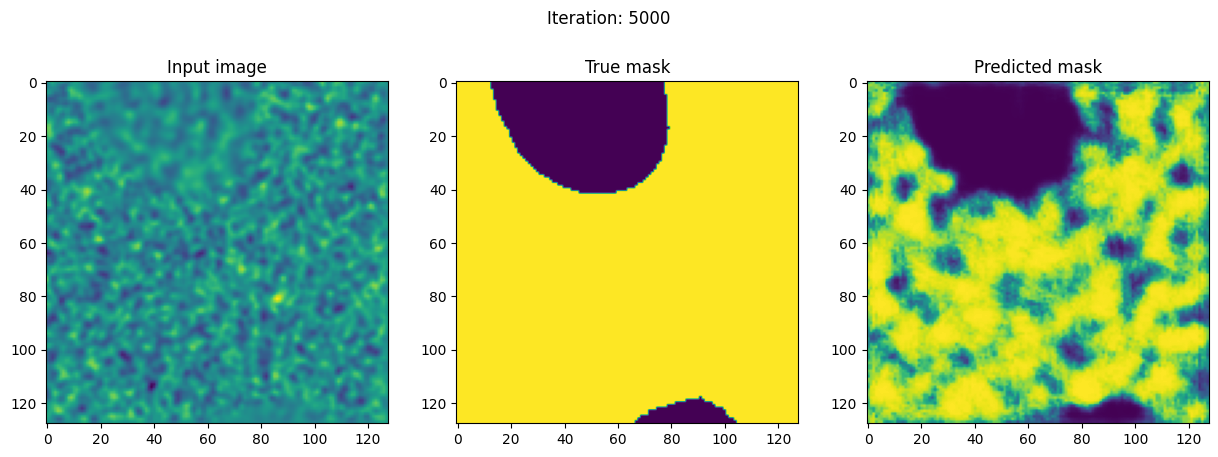

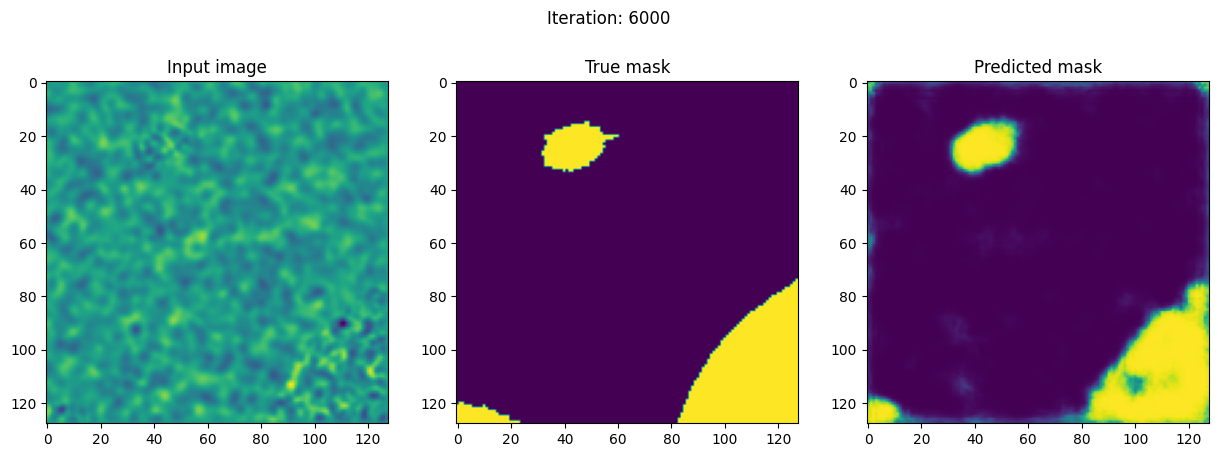

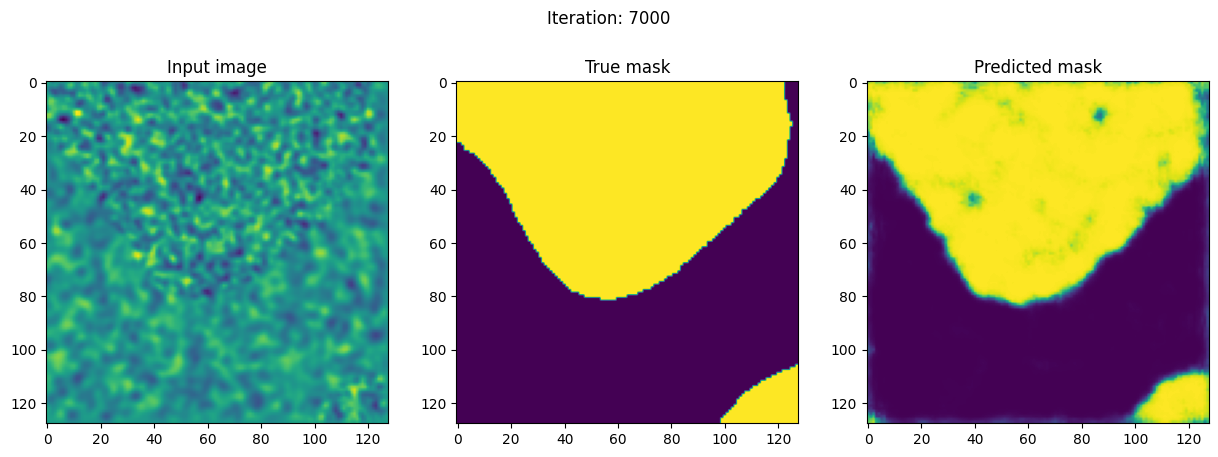

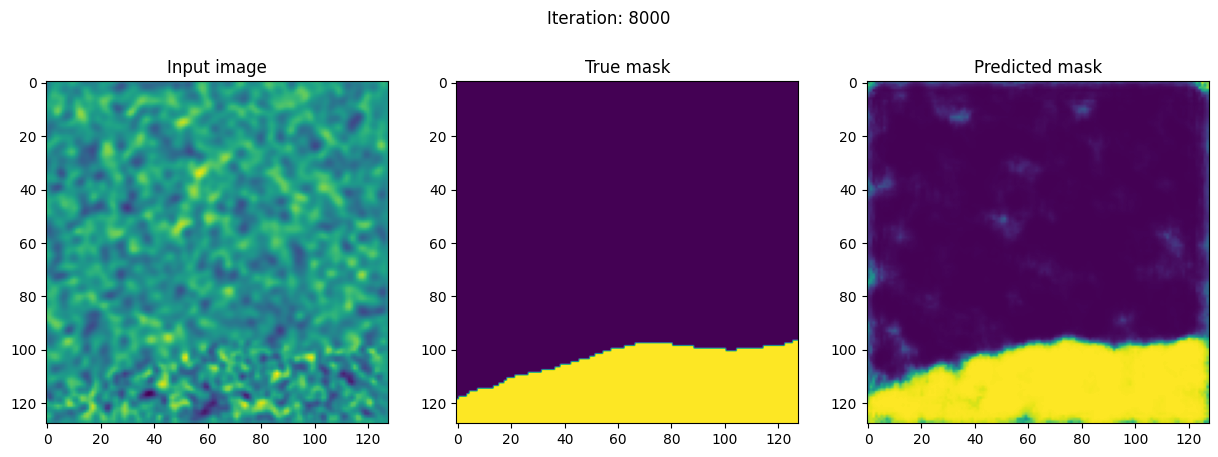

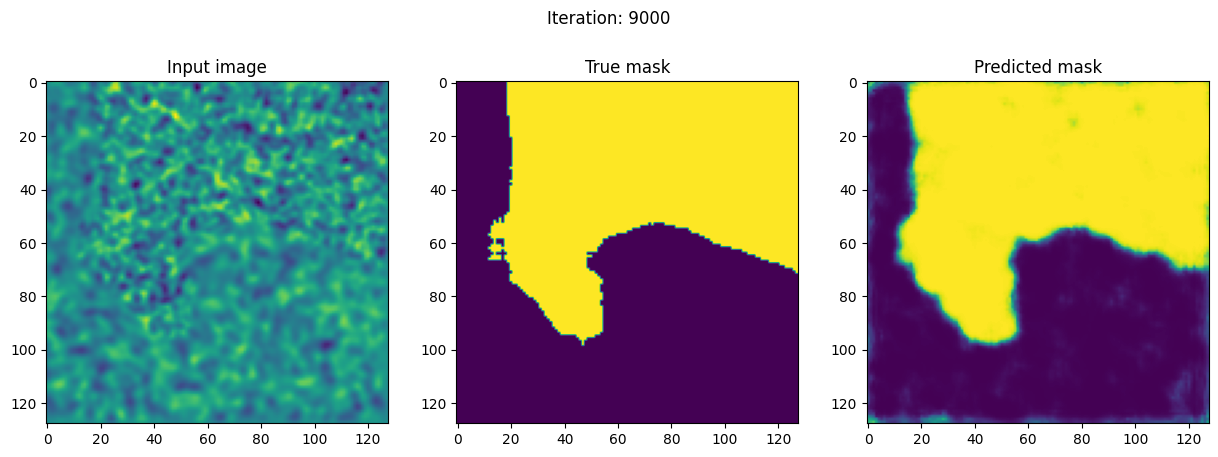

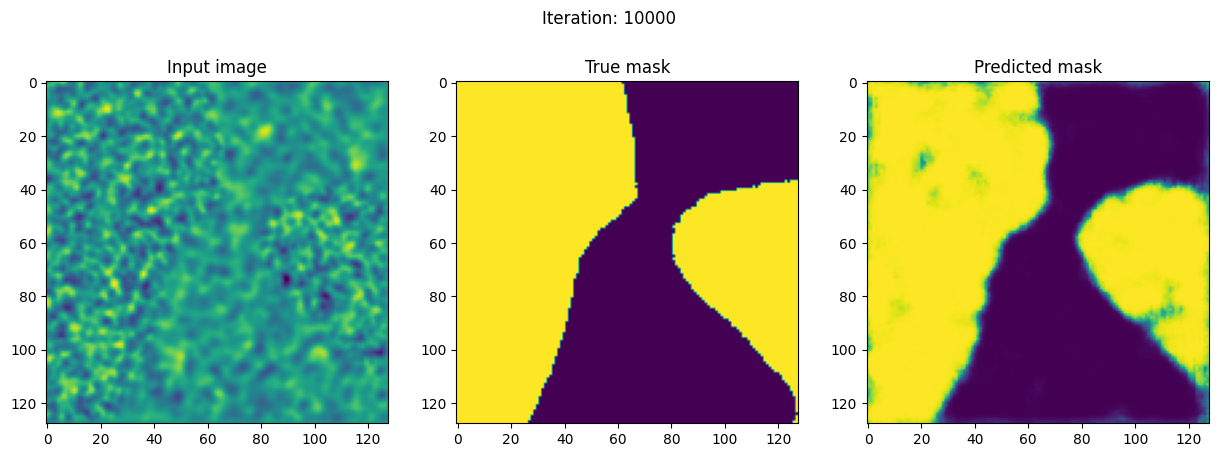

In [15]:
num_train_iteration = 10000
batch_size = 8
display_prediction_every = 1000
image_size = 128
sigma1 = 0.2
sigma2 = 1.2
sigma = image_size / 5


t = tqdm(range(num_train_iteration))
avg_loss = 0
loss_tracking = []

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)

    # Step 1: ...
    optimizer.zero_grad()

    # Step 2: ...
    predicted_omega_1 = model(x)

    # Step 3:...
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

    # Step 4:...
    loss.backward()

    # Step 5:...
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()
    loss_tracking.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

#### Question: What is the loss function used here? If you have any idea about the loss function, don't hesitate to change it.

See the evolution of the average loss over the training process.

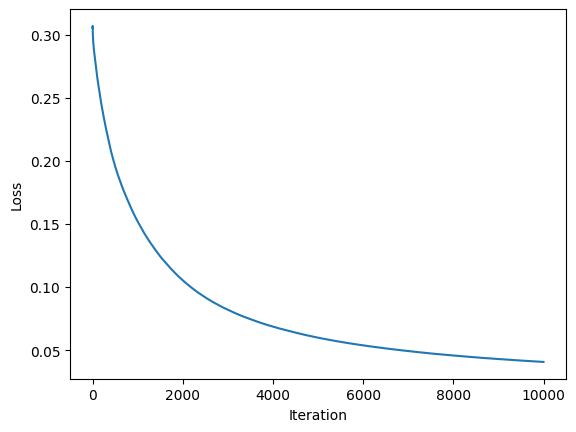

In [16]:
plt.plot(loss_tracking)
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

If you are satisfied with the result, save your model:

In [17]:
state_dict = model.state_dict()
torch.save(state_dict, "best_model.pt")

## Practical section: Train your best model
See the influence of each parameter:
- `sigma1`, `sigma2` and `sigma` are parameters which difine the difficulty of the problem.

And

- Try different optimizers and learning rates (see `torch.optim` in [this link](https://pytorch.org/docs/stable/optim.html#algorithms) ). Compare the performance. 
- What happens if the learning rate is too large? too small?
- How to evaluate the performance of your model?
- With a limit training time, try to train your best model.
